In [1]:
import numpy as np
from scipy import linalg
import matplotlib
import matplotlib.pyplot as plt
import re
import os
import json
from collections import defaultdict
from pprint import pprint
import numpy as np
import math
import pandas as pd
import progressbar

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

# spacy
import spacy
en = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# gensim
from gensim.models import Word2Vec
import gensim

In [2]:
# stop words
stop_words = stopwords.words("english")
custom_stop_words = open("stop_words.txt", "r" ).readlines()
custom_stop_words = [w.strip() for w in custom_stop_words]
custom_stop_words.extend(stop_words)
# filter_words.extend(custom_stop_words)
print("Stop words list has %d entries" % len(custom_stop_words) )

Stop words list has 533 entries


In [3]:
# import data
data = json.load(open('covid_tweets_100000.json', 'r'))
lemmas = [d['lemma'].split(' ') for d in data]
pos_tags = [d['pos'].split(' ') for d in data]
users = [d['user'] for d in data]
texts = [d['text'] for d in data]
assert(len(lemmas[0])==len(pos_tags[0]))
print(len(lemmas))
print(len(users))

73787
73787


In [4]:
def allow_pos_tags(tag, allowed_tags):
    for t in allowed_tags:
        if tag.startswith(t):
            return True
    return False

lemmas_mod = []
for i in range(len(lemmas)):
    lemma = lemmas[i]
    pos = pos_tags[i]
    lemma_out = []
    for j in range(len(lemma)):
        if allow_pos_tags(pos[j], ['VB','NN','RB','JJ']):
            lemma_out.append(lemma[j])
    lemmas_mod.append(lemma_out)
    
keywords = ["covid", "covid_19", "coronavirus", "corona", "covid-19", "corona virus",
            "covid_19", "chinesevirus", "chinese virus", "chinese_virus", "chinese-virus", "virus"]
lemmas_mod = [[l for l in d if l not in keywords] for d in lemmas_mod]

In [5]:
print(len(lemmas_mod))

73787


In [6]:
# compute bigrams and trigrams
print('Building bigram model ...')
bigrams = gensim.models.Phrases(lemmas_mod, min_count=5, threshold=100)
bigrams_mod = gensim.models.phrases.Phraser(bigrams)

print('Building trigram model ...')
trigrams = gensim.models.Phrases(bigrams[lemmas_mod], threshold=100)
trigrams_mod = gensim.models.phrases.Phraser(trigrams)

docs = [bigrams_mod[doc] for doc in lemmas_mod]
docs = [trigrams_mod[bigrams_mod[doc]] for doc in lemmas_mod]
docs = [' '.join(d) for d in docs]
print(len(docs))
# docs = list(filter(None, docs))
# docs = [d.split(' ') for d in docs]
print("Imported %d documents" % len(docs))

Building bigram model ...
Building trigram model ...
73787
Imported 73787 documents


In [71]:
keep_idx = np.array([i for i in range(len(docs)) if docs[i]])
print(len(keep_idx))

73760


In [75]:
users = np.array(users)[keep_idx]
docs = np.array(docs)[keep_idx]
texts = np.array(texts)[keep_idx]
print(len(users))

73760


In [9]:
# tf-idf vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df=20, max_df=0.9)
A = vectorizer.fit_transform(docs)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]))

# extract the resulting vocabulary
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Created 73760 X 3126 TF-IDF-normalized document-term matrix
Vocabulary has 3126 distinct terms


In [10]:
# build word embedding
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

import gensim
docgen = TokenGenerator( docs, custom_stop_words )
# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)
print("Model has %d terms" % len(w2v_model.wv.vocab))

# caculate coherence score
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(w2v_model.wv.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

import numpy as np
from itertools import combinations
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

# caculate coherence score
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(w2v_model.wv.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Model has 3157 terms


In [11]:
from sklearn import decomposition

k_min, k_max = 55, 55
step = 1
topic_models = []
topic_weights = []
coherence_values = []

for k in range(k_min, k_max+1, step):
    print("Applying topic modeling for k=%d ..." % k)
    # model = decomposition.NMF(init="nndsvd", n_components=k)
    model = decomposition.LatentDirichletAllocation(n_components=k, 
                                                    max_iter=100, 
                                                    batch_size=512,
                                                    random_state=0,
                                                    learning_method='online')
    W = model.fit_transform(A)
    H = model.components_
    # coherence
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append(get_descriptor( terms, H, topic_index, 100) )
    coherence = calculate_coherence(w2v_model, term_rankings)
    perplexity = model.bound_
    print("K=%02d: Coherence=%.4f, Perplexity=%.4f" % ( k, coherence, perplexity ) )
    
    # store for later
    topic_models.append(model)
    topic_weights.append(W)
    coherence_values.append(coherence)

Applying topic modeling for k=55 ...
K=55: Coherence=0.3727, Perplexity=20258.4827


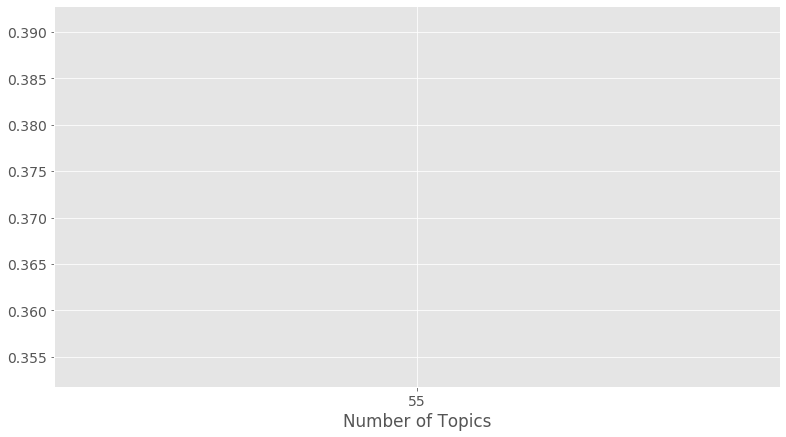

In [18]:
# plot coherence scores
k_values = range(k_min, k_max+1, step)
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot(k_values, coherence_values, 'b', label='Coherence')
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.show()

In [12]:
k_best = 0
best_model = topic_models[k_best]
topic_weight = topic_weights[k_best]
# pprint(best_model.print_topics())

In [13]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(best_model, A, vectorizer, mds='PCoA')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9     -0.119354  0.008660       1        1  3.232516
48    -0.085283 -0.181755       2        1  3.125614
2     -0.117671  0.054608       3        1  2.797844
1     -0.081993  0.000601       4        1  2.698569
49    -0.058477 -0.097345       5        1  2.580106
34    -0.064717 -0.074457       6        1  2.442187
14    -0.128399  0.078730       7        1  2.435870
38    -0.126411  0.102082       8        1  2.334017
44    -0.010962  0.180944       9        1  2.320515
12    -0.156442 -0.107432      10        1  2.318684
8     -0.067596 -0.035407      11        1  2.252012
10    -0.102708  0.033014      12        1  2.149394
28    -0.101527 -0.087097      13        1  2.124804
39    -0.054825  0.047678      14        1  2.121916
22    -0.105504  0.028318      15        1  2.092644
23    -0.107820 -0.022511      16        1  2.002032
40    -0.099269 -0.055393      17        1  1.988965
15     0.045353  0.069196      18        1  1.944329
18    -0.043562  0.026142      19        1  1.929066
43    -0.067610 -0.036276      20        1  1.915393
31    -0.017874  0.082684      21        1  1.912381
37    -0.013890  0.059324      22        1  1.906851
24    -0.050564 -0.036262      23        1  1.899665
52    -0.076360 -0.034218      24        1  1.875737
36    -0.013960  0.001857      25        1  1.781696
46     0.051823  0.202137      26        1  1.771295
42    -0.027901 -0.051722      27        1  1.770859
51    -0.014970 -0.133003      28        1  1.673578
53     0.033998  0.091676      29        1  1.668597
26    -0.045315  0.051558      30        1  1.665853
20     0.029013  0.011798      31        1  1.625799
45    -0.035219  0.041495      32        1  1.603716
19     0.086143 -0.113490      33        1  1.599037
3      0.000557 -0.031143      34        1  1.577040
29    -0.028996  0.070790      35        1  1.552059
35     0.081190  0.028673      36        1  1.537656
0      0.021611  0.068532      37        1  1.507808
6      0.144545  0.025886      38        1  1.501933
25    -0.011993  0.013563      39        1  1.499430
27     0.120919  0.003128      40        1  1.483556
5      0.128578 -0.018035      41        1  1.461680
11     0.134040 -0.085922      42        1  1.459794
17     0.082304  0.127326      43        1  1.450369
16     0.042874  0.130503      44        1  1.429370
13     0.037022 -0.058701      45        1  1.381210
7      0.069029  0.079648      46        1  1.361459
50     0.044563  0.022811      47        1  1.360509
21     0.092101 -0.113099      48        1  1.346295
32     0.061792 -0.188664      49        1  1.296594
33     0.114945 -0.059808      50        1  1.289164
41     0.107044 -0.063204      51        1  1.285404
4      0.064129 -0.025972      52        1  1.250917
47     0.108595 -0.059089      53        1  1.206144
30     0.186968 -0.084017      54        1  1.129333
54     0.148037  0.110656      55        1  1.070735, topic_info=          Term         Freq        Total Category  logprob  loglift
395       case  1161.000000  1161.000000  Default  30.0000  30.0000
2051  positive   669.000000   669.000000  Default  29.0000  29.0000
810     doctor   374.000000   374.000000  Default  28.0000  28.0000
453    chinese   470.000000   470.000000  Default  27.0000  27.0000
2506      show   361.000000   361.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1147      gain    18.696489    19.692713  Topic55  -4.5608   4.4849
2305    resort    18.355908    19.352132  Topic55  -4.5792   4.4840
2840   tourism    17.822286    18.818511  Topic55  -4.6087   4.4824
1165       get   203.143200  1416.931387  Topic55  -2.1753   2.5945
1980    people    73.064255  1267.466288  Topic55  -3.1978   1.6834

[2220 rows x 6 columns], token_table=      Topic      Freq                   Term
term                                 

In [14]:
from sklearn.manifold import TSNE
print(topic_weight.shape)
# dominant topic number in each document
topic_num = np.argmax(topic_weight, axis=1)

# tSNE dimension reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(topic_weight)

(73760, 55)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 73760 samples in 0.399s...
[t-SNE] Computed neighbors for 73760 samples in 362.488s...
[t-SNE] Computed conditional probabilities for sample 1000 / 73760
[t-SNE] Computed conditional probabilities for sample 2000 / 73760
[t-SNE] Computed conditional probabilities for sample 3000 / 73760
[t-SNE] Computed conditional probabilities for sample 4000 / 73760
[t-SNE] Computed conditional probabilities for sample 5000 / 73760
[t-SNE] Computed conditional probabilities for sample 6000 / 73760
[t-SNE] Computed conditional probabilities for sample 7000 / 73760
[t-SNE] Computed conditional probabilities for sample 8000 / 73760
[t-SNE] Computed conditional probabilities for sample 9000 / 73760
[t-SNE] Computed conditional probabilities for sample 10000 / 73760
[t-SNE] Computed conditional probabilities for sample 11000 / 73760
[t-SNE] Computed conditional probabilities for sample 12000 / 73760
[t-SNE] Computed conditional probabi

In [68]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
from bokeh.palettes import Dark2, Paired, Spectral, PuBuGn, YlGnBu
from collections import Counter

# plot the topic clusters using Bokeh
output_notebook()
n_topics = 6
freq = np.asarray(np.unique(topic_num, return_counts=True)).T
top_freq = np.array(sorted(freq, key=lambda x: x[1], reverse=1))[:n_topics]
print(top_freq)
top_topic_idx = top_freq[:,0]
print(top_topic_idx)
sub_idx = np.array([i for i in range(topic_num.shape[0]) if topic_num[i] in top_topic_idx])
sub_tsne_lda = tsne_lda[sub_idx,:]
sub_topic_num = topic_num[sub_idx]

colors = np.array(YlGnBu[9][:n_topics])
topic2color = dict(zip(top_topic_idx, colors))
labels = ['Global News', 'Political Discussion', 'Social Distancing', 'School Closing', 'Local News', 'China Controversy']
topic2label = dict(zip(top_topic_idx, labels))
print(topic2color)
print(topic2label)
# color_idx = np.array([topic2color[i] for i in sub_topic_num])

plot = figure(title="t-SNE Clustering of {} Most Frequent LDA Topics".format(n_topics), plot_width=900, plot_height=700)


Loading BokehJS ...

[[  48 3394]
 [   9 3071]
 [   2 2700]
 [   1 2500]
 [  49 2306]
 [  38 2211]]
[48  9  2  1 49 38]
{48: '#081d58', 9: '#253494', 2: '#225ea8', 1: '#1d91c0', 49: '#41b6c4', 38: '#7fcdbb'}
{48: 'Global News', 9: 'Political Discussion', 2: 'Social Distancing', 1: 'School Closing', 49: 'Local News', 38: 'China Controversy'}


In [69]:
for topic in top_topic_idx:
    topic_idx = np.array([i for i in range(sub_topic_num.shape[0]) if sub_topic_num[i]==topic])
#     print(topic_idx)
    plot.circle(x=sub_tsne_lda[topic_idx,0], 
                y=sub_tsne_lda[topic_idx,1],
                legend_label=topic2label[topic],
                color=topic2color[topic])


plot.legend.label_text_font_size = '18pt'
plot.legend.location = "bottom_right"
plot.legend.click_policy="hide"
show(plot)

In [26]:
print(H.shape)
print(A.shape)

(55, 3126)
(73760, 3126)


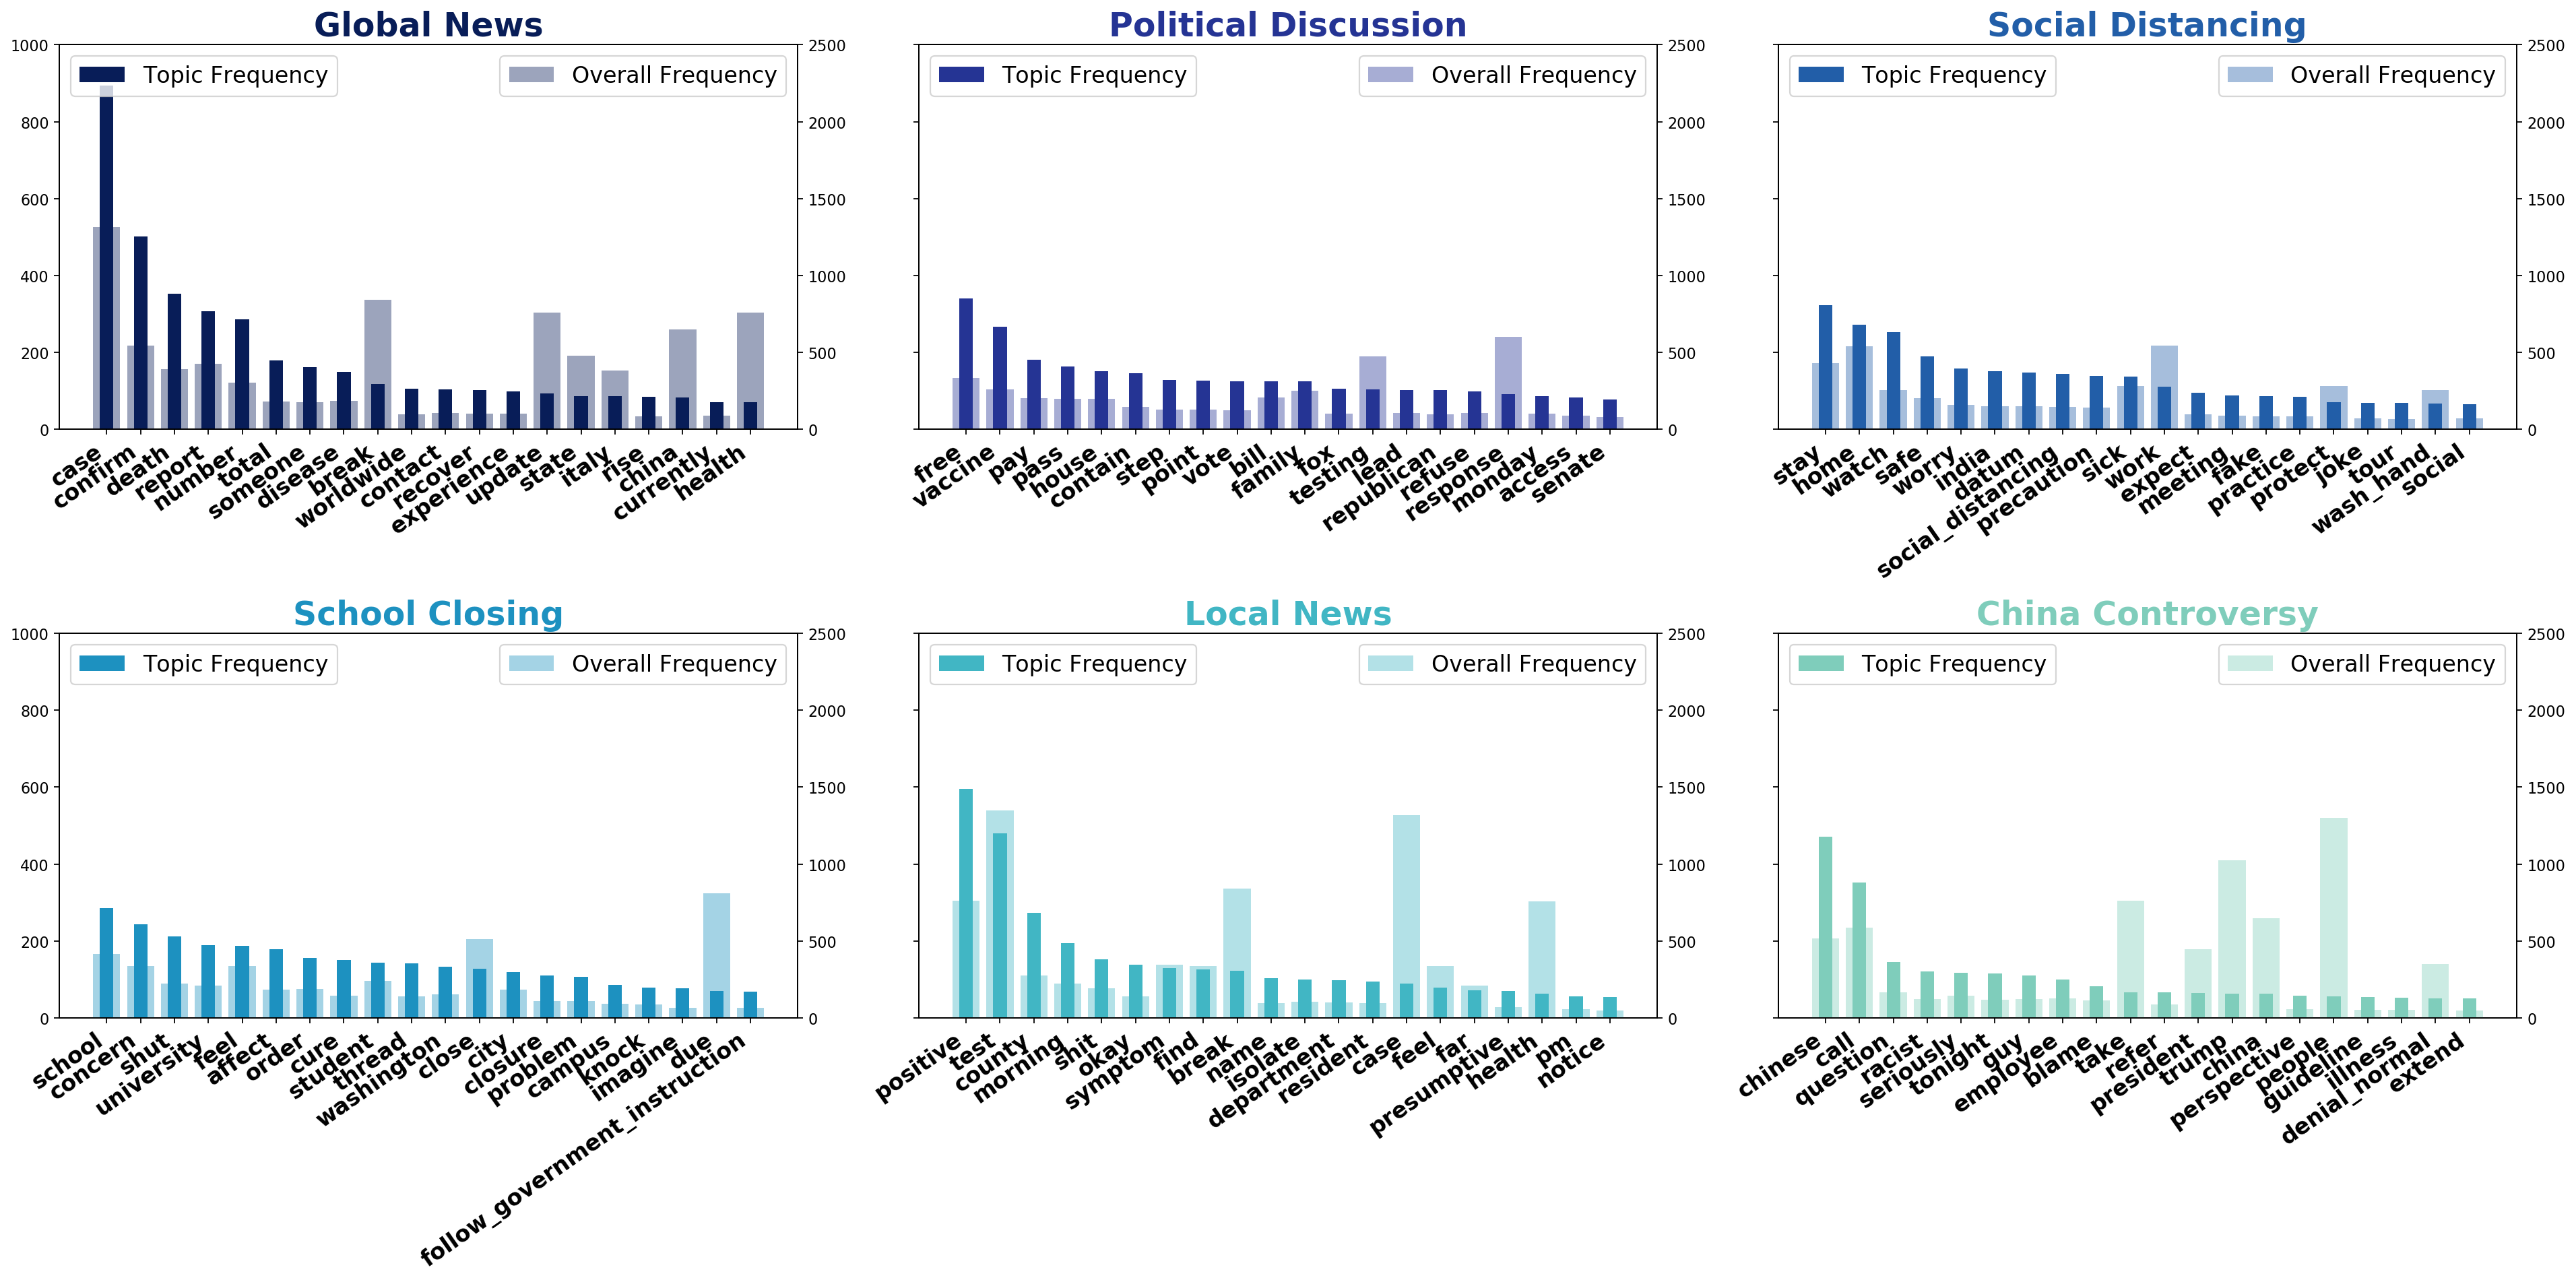

In [65]:
def extract_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    top_counts = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
        top_counts.append(np.sum(A[:,term_index]))
    # note we reverse the ordering for the plot
#     top_terms.reverse()
#     top_weights.reverse()
    # create the plot
#     fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
#     ax = plt.barh(ypos, top_weights, align="center", color=topic2color[topic_index], alpha=1, height=0.5, tick_label=top_terms)
#     plt.xlabel("Term Weight",fontsize=14)
#     plt.xticks(rotation='vertical')
#     plt.tight_layout()
#     plt.show()
    return ypos, top_weights, top_terms, top_counts
    

# plot_top_term_weights(terms, H, 9, 20)
    
fig, axes = plt.subplots(2, 3, figsize=(24,12), sharey=True, dpi=160)
for i, ax in enumerate(axes.flatten()):
    topic_index = top_topic_idx[i]
#     print(topic_index)
    ypos, top_weights, top_terms, top_counts = extract_top_term_weights(terms, H, topic_index, 20)
    ax.bar(ypos, 
            top_weights, 
            align="center", 
            color=topic2color[topic_index], 
            width=0.4,
            tick_label=top_terms,
            label='Topic Frequency')
    ax_twin = ax.twinx()
    ax_twin.bar(ypos, 
                top_counts, 
                align="center", 
                color=topic2color[topic_index], 
                width=0.8,
                alpha=0.4,
                tick_label=top_terms,
                label='Overall Frequency')
    ax.set_title(topic2label[topic_index], color=topic2color[topic_index], fontsize=22, fontweight='bold')
    ax.set_xticklabels(top_terms, fontsize=15, rotation=35, horizontalalignment='right', fontweight='bold')
    ax.set_ylim(0, 1000)
    ax_twin.set_ylim(0, 2500)
    ax.legend(loc='upper left', prop={'size': 15})
    ax_twin.legend(loc='upper right', prop={'size': 15})
    ax_twin.grid(False)

fig.tight_layout(w_pad=1)  
# fig.suptitle('Topic-wise and Overall Frequency of Topic Keywords', fontsize=18, y=1.05)
plt.ioff()
plt.show()

In [25]:
print(len(topic_num))

73760


In [27]:
student_users = open('college_students.txt','r').readlines()
student_users = [int(u) for u in student_users]
print(len(student_users))

3460


In [29]:
non_org_users = open('covid_users_100000_non-org.jsonl','r').readlines()
non_org_users = [json.loads(u) for u in non_org_users]
non_org_users = [u['id'] for u in non_org_users]
print(len(non_org_users))

11165


In [30]:
topic_data = {}
for i in top_topic_idx:
    topic_data[i] = []

In [31]:
for i in range(len(topic_num)):
    if topic_num[i] in top_topic_idx:
        topic_data[topic_num[i]].append((users[i],texts[i]))

In [51]:
total_tweet_count = []
student_tweet_count = []

for topic in top_topic_idx:
    total_tweet_count.append(len(topic_data[topic]))
    count = 0
    student_tweets = []
    general_tweets = []
    for tweet in topic_data[topic]:
        if tweet[0] in non_org_users:
            if tweet[0] in student_users:
                count += 1
                student_tweets.append(tweet[1])
            else:
                general_tweets.append(tweet[1])
            
    with open('student_tweets_{}.txt'.format(topic2label[topic].replace(' ','_')), 'w') as f:
        for t in student_tweets:
            f.write(t+'\n')
    with open('general_tweets_{}.txt'.format(topic2label[topic].replace(' ','_')), 'w') as f:
        for t in general_tweets:
            f.write(t+'\n')
        
    student_tweet_count.append(count)
    
print(total_tweet_count)
print(student_tweet_count)

[3394, 3071, 2700, 2500, 2306, 2211]
[636, 636, 636, 801, 774, 546]


[18.7389510901591, 20.709866492999023, 23.555555555555554, 32.04, 33.564614050303554, 24.694708276797826]


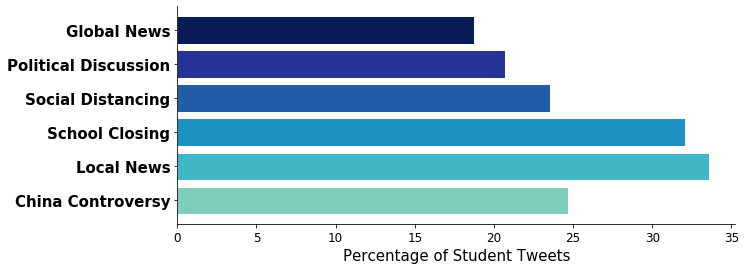

In [64]:
# plot
student_tweet_percent = [i/j*100 for i,j in zip(student_tweet_count, total_tweet_count)]
print(student_tweet_percent)
fig, ax = plt.subplots(figsize=(10,4))

for i in range(len(top_topic_idx)):
#     ax.barh(i, 100, edgecolor='white', color=topic2color[top_topic_idx[i]], label=topic2label[top_topic_idx[i]], alpha=0.7)
    ax.barh(i, student_tweet_percent[i], color=topic2color[top_topic_idx[i]], edgecolor='white', height=0.8)
    ax.invert_yaxis()
#     ax.spines["right"].set_visible(False)
#     ax.spines["top"].set_visible(False)
ax.invert_yaxis()
plt.yticks(range(6), labels, fontsize=15, horizontalalignment='right', fontweight='bold')
plt.xticks(5*np.array(range(8)), fontsize=12)
plt.xlabel('Percentage of Student Tweets', fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.title("Contributions of Student Tweets Per Topic", fontsize=20)

In [260]:
topic = 38
topic_sentiments = open('student_sentiments_{}.txt'.format(topic2label[topic].replace(' ','_')), 'r').readlines()
topic_sentiments = [int(s) for s in topic_sentiments]
print(len(topic_sentiments))

topic_docs = []

for i in range(len(topic_num)):
    if topic_num[i] == topic and users[i] in student_users:
        topic_docs.append(docs[i])
        
print(len(topic_docs))

546
546


In [261]:
topic_docs = [topic_docs[i] for i in range(len(topic_docs)) if topic_sentiments[i] in [0,2]]
topic_sentiments = [s for s in topic_sentiments if s in [0,2]]

In [262]:
print(len(topic_docs))
print(len(topic_sentiments))

422
422


In [263]:
# tf-idf vectorization
sub_vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df=5, max_df=0.9)
sub_A = sub_vectorizer.fit_transform(topic_docs)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (sub_A.shape[0], sub_A.shape[1]))

# extract the resulting vocabulary
sub_terms = sub_vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(sub_terms))

Created 422 X 102 TF-IDF-normalized document-term matrix
Vocabulary has 102 distinct terms


In [264]:
sub_docgen = TokenGenerator( topic_docs, custom_stop_words )
# the model has 500 dimensions, the minimum document-term frequency is 20
sub_w2v_model = gensim.models.Word2Vec(sub_docgen, size=500, min_count=5, sg=1)
print("Model has %d terms" % len(sub_w2v_model.wv.vocab))

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Model has 103 terms


In [265]:
k_min, k_max = 3, 3
step = 1
sub_topic_models = []
sub_topic_weights = []
sub_coherence_values = []

for k in range(k_min, k_max+1, step):
    print("Applying topic modeling for k=%d ..." % k)
    # model = decomposition.NMF(init="nndsvd", n_components=k)
    sub_model = decomposition.LatentDirichletAllocation(n_components=k, 
                                                    max_iter=100, 
                                                    batch_size=16,
                                                    random_state=0,
                                                    learning_method='online')
    sub_W = sub_model.fit_transform(sub_A)
    sub_H = sub_model.components_
    # coherence
    sub_term_rankings = []
    for topic_index in range(k):
        sub_term_rankings.append(get_descriptor( sub_terms, sub_H, topic_index, 20) )
    coherence = calculate_coherence(sub_w2v_model, sub_term_rankings)
    perplexity = sub_model.bound_
    print("K=%02d: Coherence=%.4f, Perplexity=%.4f" % ( k, coherence, perplexity ) )
    
    # store for later
    sub_topic_models.append(sub_model)
    sub_topic_weights.append(sub_W)
    sub_coherence_values.append(coherence)

Applying topic modeling for k=3 ...
K=03: Coherence=0.9995, Perplexity=104.0867


In [266]:
sub_k_best = 0
best_sub_model = sub_topic_models[sub_k_best]
sub_topic_weight = sub_topic_weights[sub_k_best]


import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(best_sub_model, sub_A, sub_vectorizer, mds='PCoA')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.092610 -0.232326       1        1  36.149827
2     -0.273889  0.045258       2        1  34.213386
1      0.181279  0.187068       3        1  29.636787, topic_info=         Term       Freq      Total Category  logprob  loglift
40        guy  27.000000  27.000000  Default  30.0000  30.0000
35        get  22.000000  22.000000  Default  29.0000  29.0000
11       call  51.000000  51.000000  Default  28.0000  28.0000
45       keep  20.000000  20.000000  Default  27.0000  27.0000
66  president  22.000000  22.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
95       want   0.382052   4.631775   Topic3  -6.5430  -1.2790
49        lot   0.330542   3.594575   Topic3  -6.6878  -1.1703
8       break   0.336643   3.941437   Topic3  -6.6695  -1.2441
56       need   0.348995   6.331996   Topic3  -6.6335  -1.6822
7       blame   0.334939  13.841407   Topic3  -6.6746  -2.5053

[139 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
0         2  0.934831                alone
2         1  0.937567             american
3         2  0.875403                asian
4         2  0.962655                  ass
6         3  0.922409     bernie_town_hall
...     ...       ...                  ...
97        2  0.766438           white_hous
98        1  0.907412          white_house
99        3  0.962464  white_mass_shooting
100       1  0.921881               wonder
101       3  0.909215                wuhan

[103 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [267]:
# dominant topic number in each document
sub_topic_num = np.argmax(sub_topic_weight, axis=1)

In [268]:
sub_freq = np.asarray(np.unique(sub_topic_num, return_counts=True)).T
sub_top_freq = np.array(sorted(sub_freq, key=lambda x: x[1], reverse=1))
print(sub_top_freq)

[[  0 164]
 [  2 149]
 [  1 109]]


In [269]:
_, _, sub_top_terms, _ = extract_top_term_weights(sub_terms, sub_H, 0, 20)
print(sub_top_terms)

['chinese', 'president', 'call', 'racist', 'refer', 'flu', 'reply', 'people', 'fuck', 'trump', 'official', 'brother', 'white_house', 'wonder', 'vote', 'morning', 'face', 'china', 'blame', 'american']


In [270]:
sub_freq = np.asarray(np.unique(topic_sentiments, return_counts=True)).T
sub_top_freq = np.array(sorted(sub_freq, key=lambda x: x[1], reverse=1))
print(sub_top_freq)

[[  0 401]
 [  2  21]]


In [273]:
count = 0
for i in range(len(sub_topic_num)):
    if sub_topic_num[i]==1 and topic_sentiments[i] == 0:
        count += 1
               
print(count)

100
